In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator 
from yellowbrick.cluster import silhouette_visualizer 
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.datasets import make_blobs

from decimal import Decimal

In [177]:
data = pd.read_csv('../data/bike_clean.csv')
data = data[data.rent_count > 0].reset_index(drop=True)

In [178]:
data.describe()

,Unnamed: 0,hour,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall
count,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.00000,8465.000000
mean,4293.746958,11.507029,729.156999,12.771057,58.147194,1.725883,14338.734790,3.944997,0.567868,0.14912,0.776846
std,2512.337497,6.920899,642.351166,12.104375,20.484839,1.034281,6090.512294,13.242399,0.868245,1.12554,4.440633
min,1.000000,0.000000,2.000000,-17.800000,0.000000,0.000000,270.000000,-30.600000,0.000000,0.00000,0.000000
25%,2117.000000,6.000000,214.000000,3.000000,42.000000,0.900000,9350.000000,-5.100000,0.000000,0.00000,0.000000
50%,4281.000000,12.000000,542.000000,13.500000,57.000000,1.500000,16900.000000,4.700000,0.010000,0.00000,0.000000
75%,6397.000000,18.000000,1084.000000,22.700000,74.000000,2.300000,20000.000000,15.200000,0.930000,0.00000,0.000000
max,8760.000000,23.000000,3556.000000,39.400000,98.000000,7.400000,20000.000000,27.200000,3.520000,35.00000,88.000000


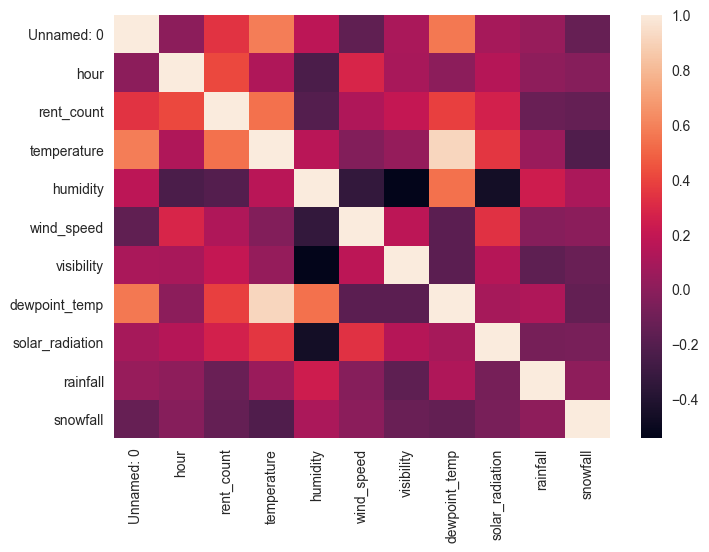

In [5]:
sns.heatmap(data.corr())
plt.show()

## K means clustering
### Scaling Data

In [6]:
# drop categorical var: holiday, season, open
# drop humidity (correlated with solar and visibility)
# drop dewpoint_temp (correlated with temperature
# drop rainfall & snowfall (more than 93% is 0)

In [7]:
df_kmean = data.drop(columns = ['Unnamed: 0','holiday', 'season', 'open', 'datetime', 'date', 'humidity','dewpoint_temp',
                               'rainfall', 'snowfall'])

In [8]:
df_kmean.columns

Index(['hour', 'rent_count', 'temperature', 'wind_speed', 'visibility',
       'solar_radiation'],
      dtype='object')

In [9]:
df_kmean.describe()

,hour,rent_count,temperature,wind_speed,visibility,solar_radiation
count,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000
mean,11.507029,729.156999,12.771057,1.725883,14338.734790,0.567868
std,6.920899,642.351166,12.104375,1.034281,6090.512294,0.868245
min,0.000000,2.000000,-17.800000,0.000000,270.000000,0.000000
25%,6.000000,214.000000,3.000000,0.900000,9350.000000,0.000000
50%,12.000000,542.000000,13.500000,1.500000,16900.000000,0.010000
75%,18.000000,1084.000000,22.700000,2.300000,20000.000000,0.930000
max,23.000000,3556.000000,39.400000,7.400000,20000.000000,3.520000


In [823]:
dataarray = df_kmean.to_numpy()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataarray) 
scaled_features

array([[-1.66132477, -0.69865046, -1.51395724,  0.45847578,  0.92587135,
        -0.65513172],
       [-1.51686175, -0.77617457, -1.53907415, -0.8925615 ,  0.92587135,
        -0.65513172],
       [-1.37239873, -0.82423951, -1.58093567, -0.69955617,  0.92587135,
        -0.65513172],
       ...,
       [ 1.37239873, -0.0164383 , -0.86091752, -1.37507481,  0.87326261,
        -0.65513172],
       [ 1.51686175,  0.01147038, -0.90277904, -0.69955617,  0.6940641 ,
        -0.65513172],
       [ 1.66132477, -0.18699134, -0.91952365, -0.41004818,  0.77626525,
        -0.65513172]])

### Evaluating WCSS

In [824]:
wcss = []
max_k = 14
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

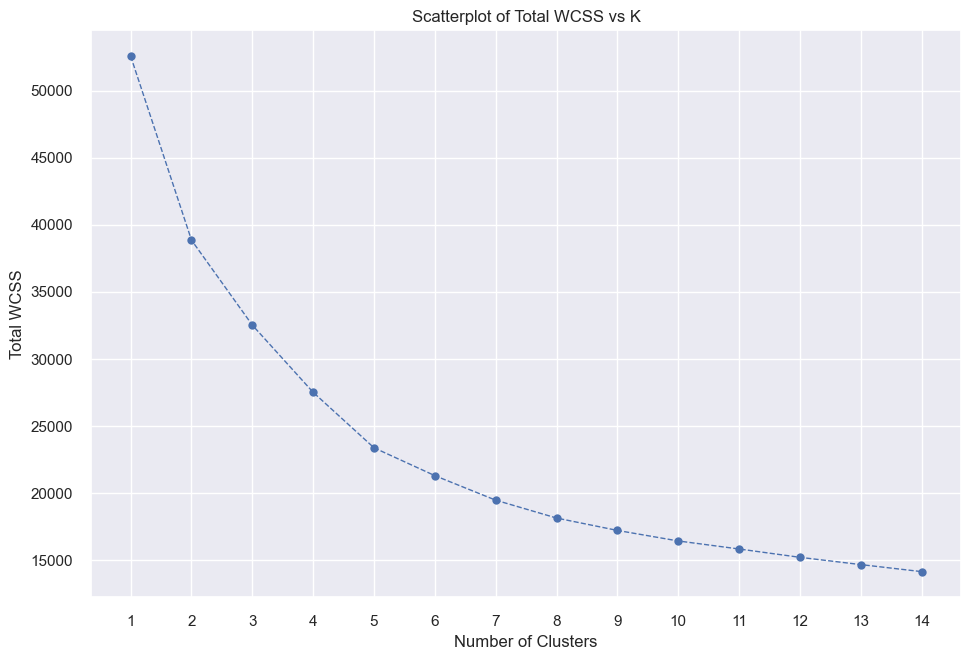

In [825]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [826]:
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

kl.elbow

5

In [827]:
silhouette_coefficients = []

for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)

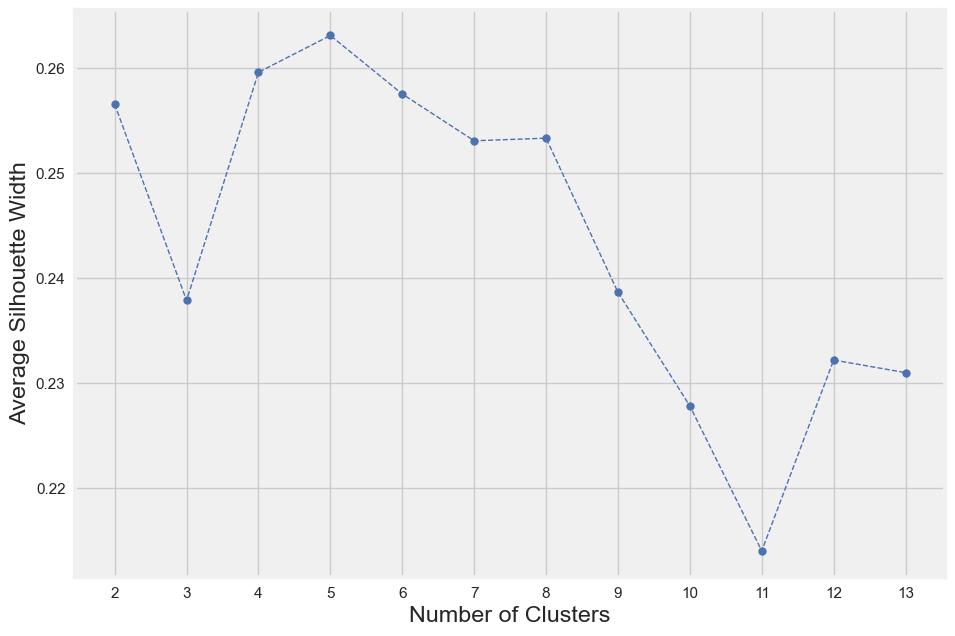

In [828]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

In [829]:
silhouette_dict = {}
def kmeans_label(data, num_clusters): 
    kmeans_model = KMeans(init = 'random', n_clusters = num_clusters, random_state=42)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data.to_numpy()) 
    kmeans_model.fit(scaled_features)
    data2 = data.copy()
    labels = kmeans_model.labels_
    data2['Clusters'] = pd.DataFrame(labels)
    return data2

def plot_boxplots(data_with_label):
    plt.figure(figsize=(30,30))
    sns.set(font_scale = 2)
    for i in range(len(data_with_label.columns)-1):
        plt.subplot(2,5,i+1)
        sns.boxplot(y=data_with_label.columns[i], x='Clusters', data=data_with_label, palette="colorblind") 
    
def plot_silhouettes(data,num_clusters):
    scaler = StandardScaler()
    dataarray = scaler.fit_transform(data.to_numpy()) 
    model = KMeans(num_clusters,random_state=42)
    plt.figure(figsize=(10, 7)) 
    sns.set(font_scale = 1)
    silhouette_visualizer(model, dataarray, colors='yellowbrick')
    score = silhouette_score(dataarray, model.labels_,metric = 'euclidean')
    if num_clusters not in silhouette_dict.keys():
        silhouette_dict[num_clusters] = score
    print("For n_clusters = {0} The average silhouette_score is: {1} ".format(num_clusters,score))

### Kmeans with 5 clusters

In [832]:
kmeans5 = KMeans(init="random",n_clusters = 5 , random_state = 42)
kmeans5.fit(scaled_features)
clustergroups5 = kmeans5.labels_
Clustercenters5 = pd.DataFrame(kmeans5.cluster_centers_)
Clustercenters5

,0,1,2,3,4,5
0,1.040619,1.570668,0.707524,0.008864,0.375439,-0.321569
1,0.576226,-0.585371,-1.061411,0.930191,0.527842,-0.177023
2,-1.021550,-0.499842,-0.163805,-0.622839,0.514385,-0.542537
3,0.212586,0.477542,0.887103,0.526782,0.277755,1.828807
4,-0.286598,-0.542212,-0.210074,-0.463491,-1.445874,-0.450054


In [833]:
print(f'CH score: {calinski_harabasz_score(scaled_features, clustergroups5)}')

CH score: 2730.3254618479536


In [729]:
model5 = kmeans_label(df_kmean, 5)
model5.head()

,hour,rent_count,temperature,wind_speed,visibility,solar_radiation,Clusters
0,0,254,-5.2,2.2,20000,0.0,2
1,1,204,-5.5,0.8,20000,0.0,2
2,2,173,-6.0,1.0,20000,0.0,2
3,3,107,-6.2,0.9,20000,0.0,2
4,4,78,-6.0,2.3,20000,0.0,1


In [730]:
model5.Clusters.value_counts(dropna=False)

2    2150
4    2018
1    1555
3    1547
0    1490
Name: Clusters, dtype: int64

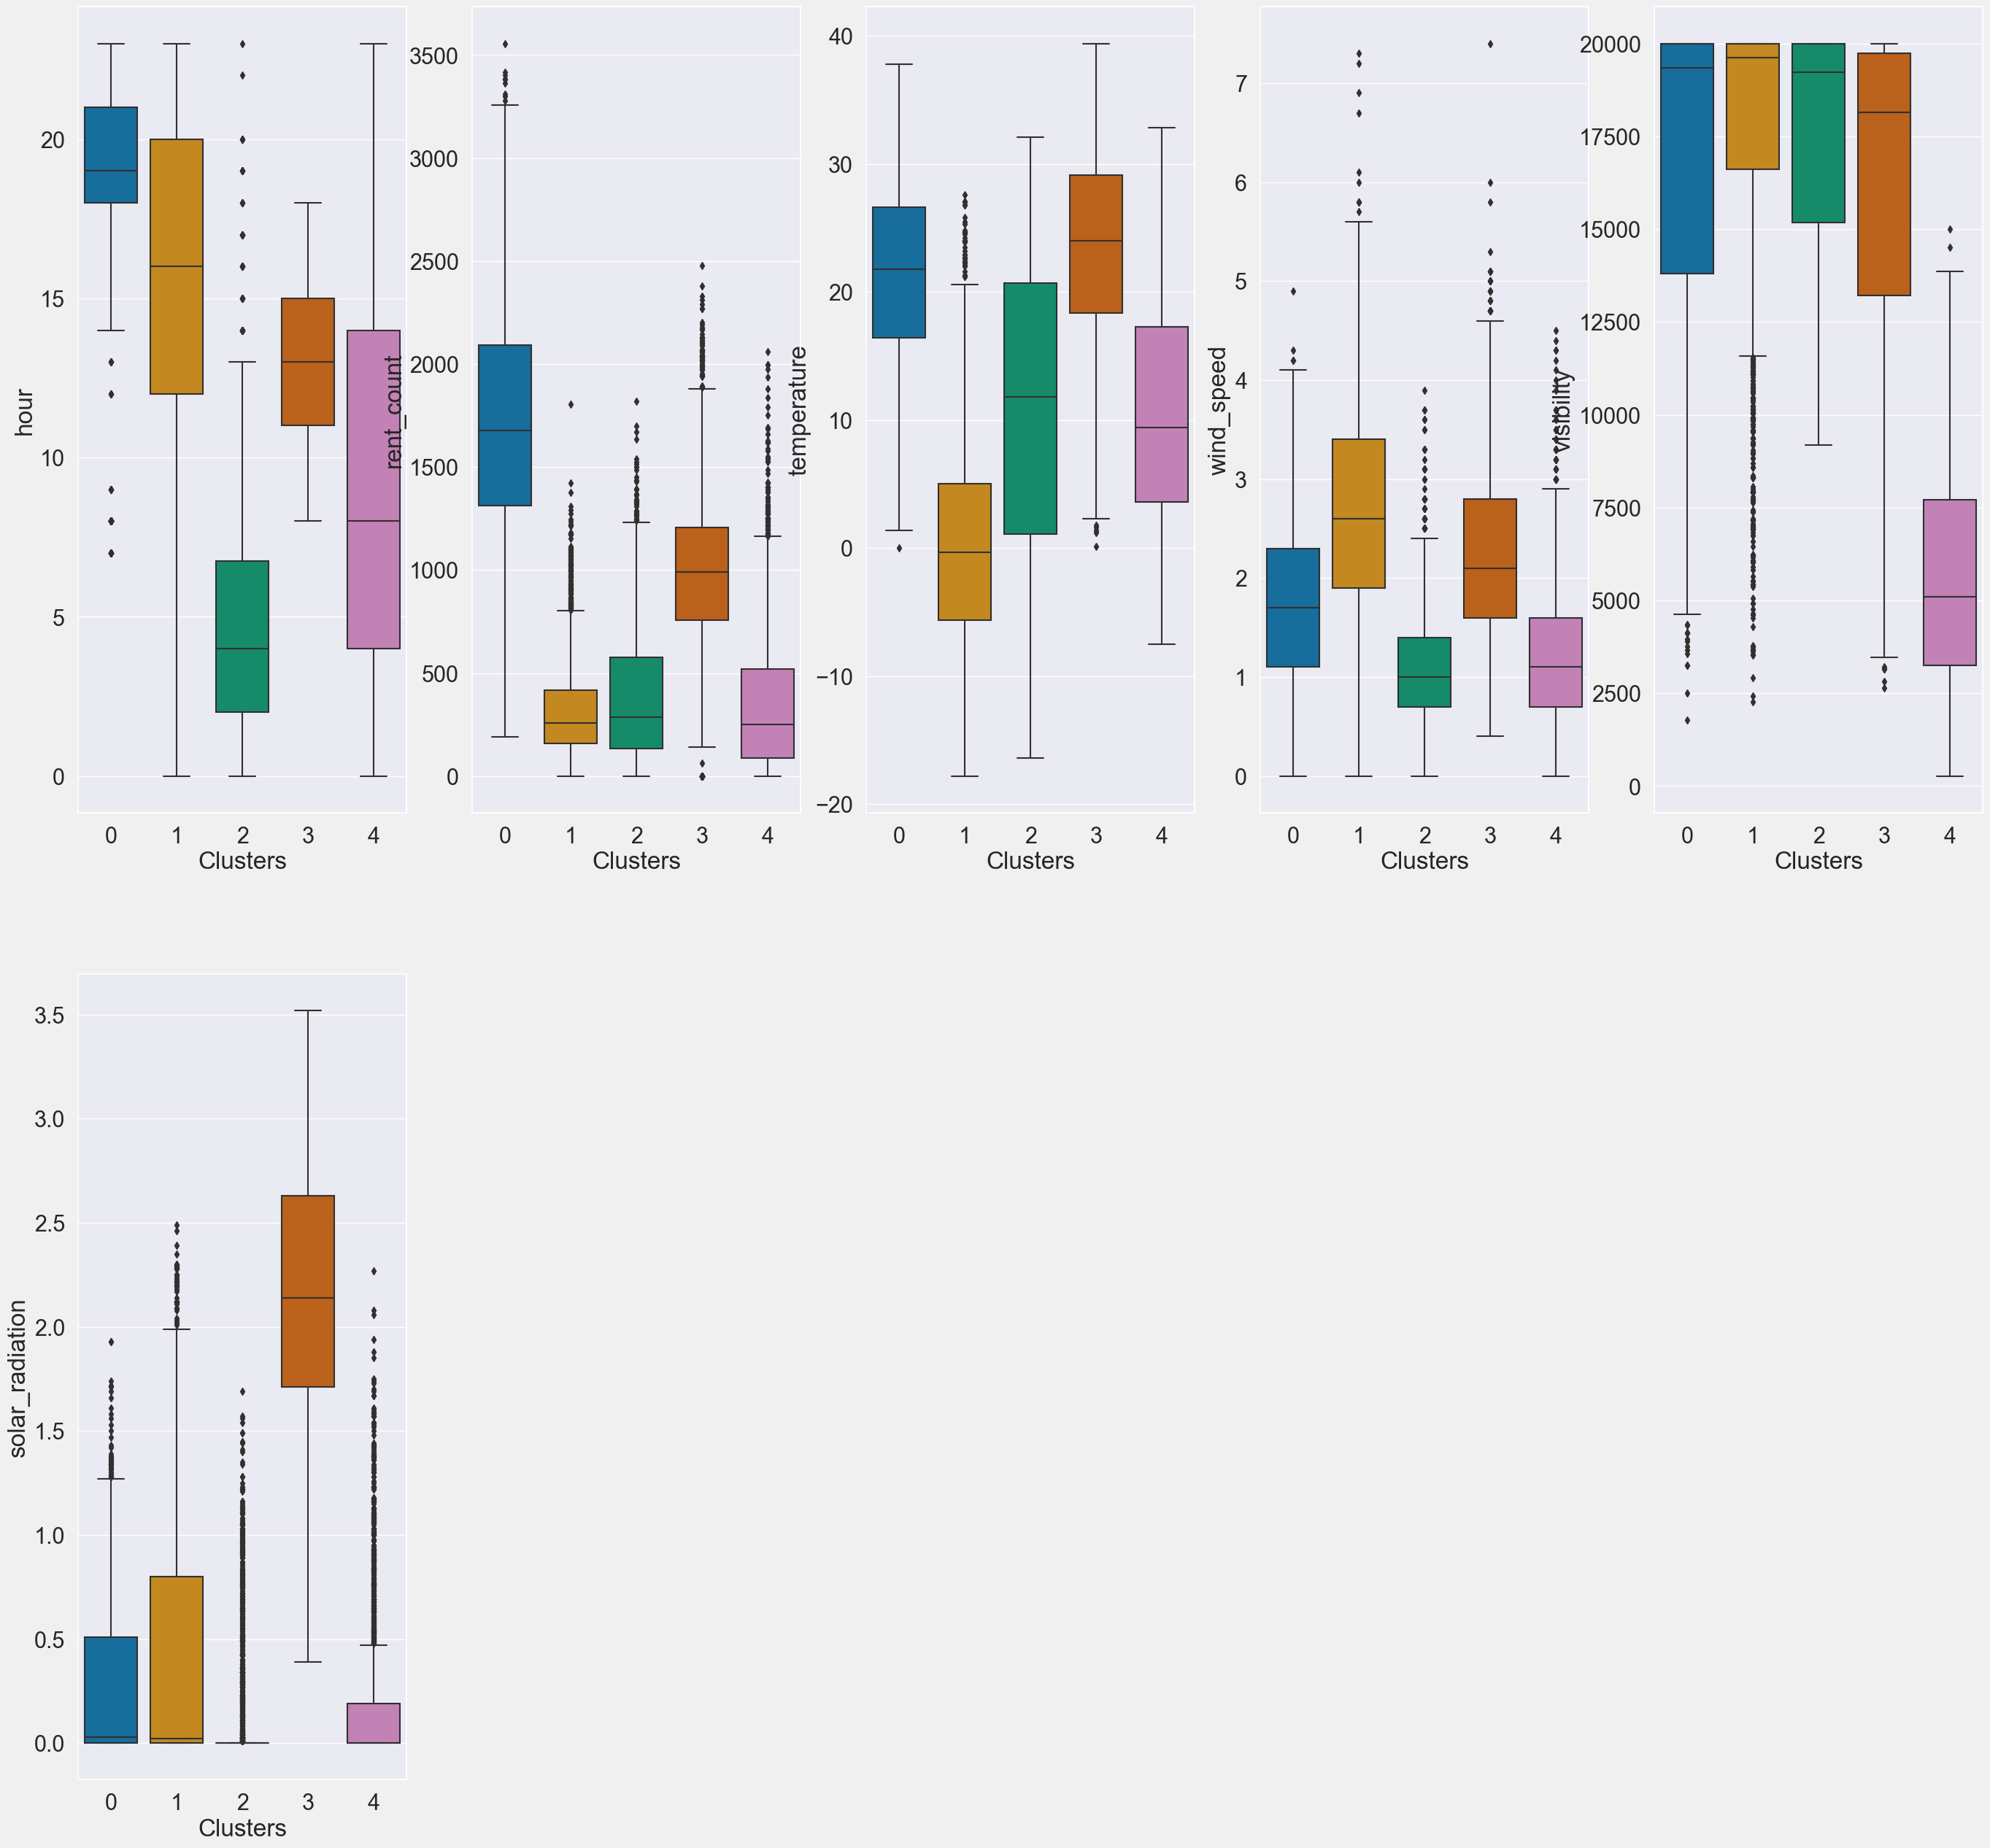

In [731]:
plot_boxplots(model5)
plt.show()

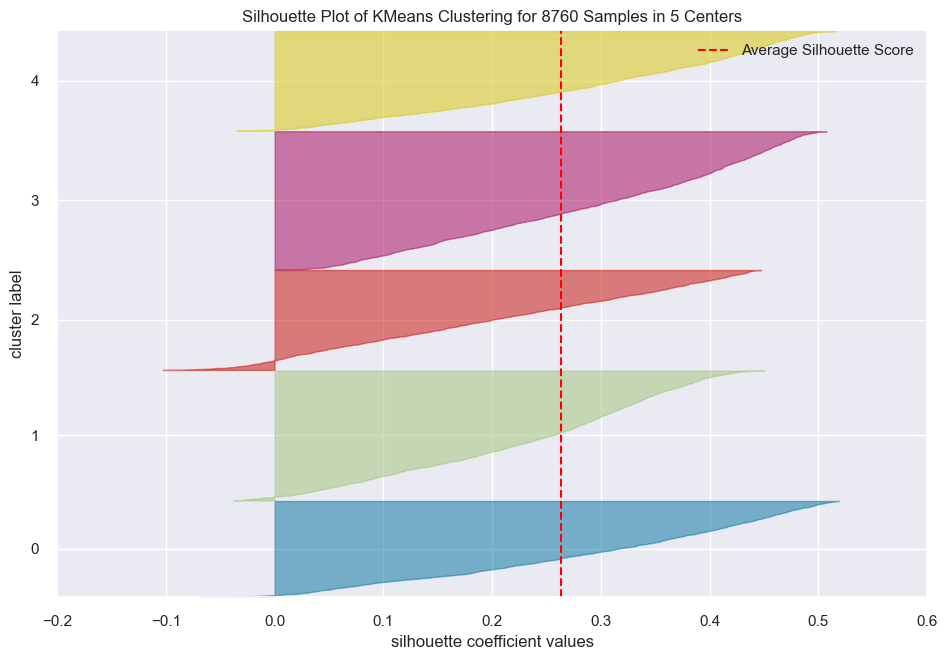

For n_clusters = 5 The average silhouette_score is: 0.2631052562486528 


In [732]:
plot_silhouettes(df_kmean,5)
plt.show()

In [742]:
Clustercenters5 = pd.DataFrame(scaler.inverse_transform(kmeans5.cluster_centers_), columns = df_kmean.columns)

In [749]:
Clustercenters5

,hour,rent_count,temperature,wind_speed,visibility,solar_radiation
0,18.703356,1717.620805,21.333691,1.734094,16651.919463,0.289765
1,15.488746,327.061093,0.205273,2.688810,17578.932476,0.415331
2,4.428638,382.223617,10.926406,1.079498,17497.075779,0.097810
3,12.971558,1012.597931,23.478604,2.270782,16057.744021,2.157789
4,9.516113,354.896877,10.373773,1.244621,5573.525037,0.178151


In [743]:
pca_final_cluster = pd.concat([model5, data[['season', 'holiday', 'open']]], axis = 1)

In [744]:
pca_season = pca_final_cluster.groupby('Clusters').season.agg(pd.Series.mode).to_frame()

In [745]:
pca_holiday = pca_final_cluster.groupby('Clusters').holiday.agg(pd.Series.mode).to_frame()

In [746]:
pca_open = pca_final_cluster.groupby('Clusters').open.agg(pd.Series.mode).to_frame()

In [747]:
final_pca_cluster = pd.concat([Clustercenters5,pca_season, pca_holiday, pca_open], axis=1)
final_pca_cluster

,hour,rent_count,temperature,wind_speed,visibility,solar_radiation,season,holiday,open
0,18.703356,1717.620805,21.333691,1.734094,16651.919463,0.289765,Summer,No Holiday,Yes
1,15.488746,327.061093,0.205273,2.688810,17578.932476,0.415331,Winter,No Holiday,Yes
2,4.428638,382.223617,10.926406,1.079498,17497.075779,0.097810,Autumn,No Holiday,Yes
3,12.971558,1012.597931,23.478604,2.270782,16057.744021,2.157789,Summer,No Holiday,Yes
4,9.516113,354.896877,10.373773,1.244621,5573.525037,0.178151,Spring,No Holiday,Yes


In [730]:
model5.Clusters.value_counts(dropna=False)

2    2150
4    2018
1    1555
3    1547
0    1490
Name: Clusters, dtype: int64

### PCA

In [42]:
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from yellowbrick.features import PCA as YBPCA
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [69]:
bike = pd.read_csv('../PCA/bike_season_as_no.csv')
bike = bike[bike.rent_count > 0].reset_index(drop=True)

In [70]:
bike3 = bike.drop(columns = ['Unnamed: 0', 'season','datetime','date','holiday','open'],inplace=False)

In [71]:
bike3.drop(columns = ['season_no', 'hour', 'rent_count'], inplace = True)
bike3.head()

,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall
0,-5.2,37,2.2,20000,-17.6,0.0,0.0,0
1,-5.5,38,0.8,20000,-17.6,0.0,0.0,0
2,-6.0,39,1.0,20000,-17.7,0.0,0.0,0
3,-6.2,40,0.9,20000,-17.6,0.0,0.0,0
4,-6.0,36,2.3,20000,-18.6,0.0,0.0,0


In [72]:
_ , p_value = calculate_bartlett_sphericity(bike3)
p_value

0.0

KMO Test

In [73]:
_, kmo_score = calculate_kmo(bike3)
kmo_score 

0.43334554939456604

In [74]:
colnames = list(bike3.columns)
scaler = StandardScaler(with_mean=True,with_std=True)
scaled_features = pd.DataFrame(scaler.fit_transform(bike3))

scaled_features.columns = colnames

In [75]:
N = len(bike3.columns)
pca = PCA(n_components=N)
pca.fit(scaled_features)

PCA(n_components=8)

In [76]:
#outputs an array of the variance explained by each component scaled to the total of 1.
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

array([0.30245802, 0.24455681, 0.13209447, 0.11699786, 0.09416029,
       0.08089102, 0.02827383, 0.0005677 ])

In [77]:
# Cumulative sum of principal components i.e. Cumulative variance of 2 = PC1 variance + PC2 variance
cumulative_variance = np.cumsum(np.round(explained_variance_ratio, decimals=3))
cumulative_variance

array([0.302, 0.547, 0.679, 0.796, 0.89 , 0.971, 0.999, 1.   ])

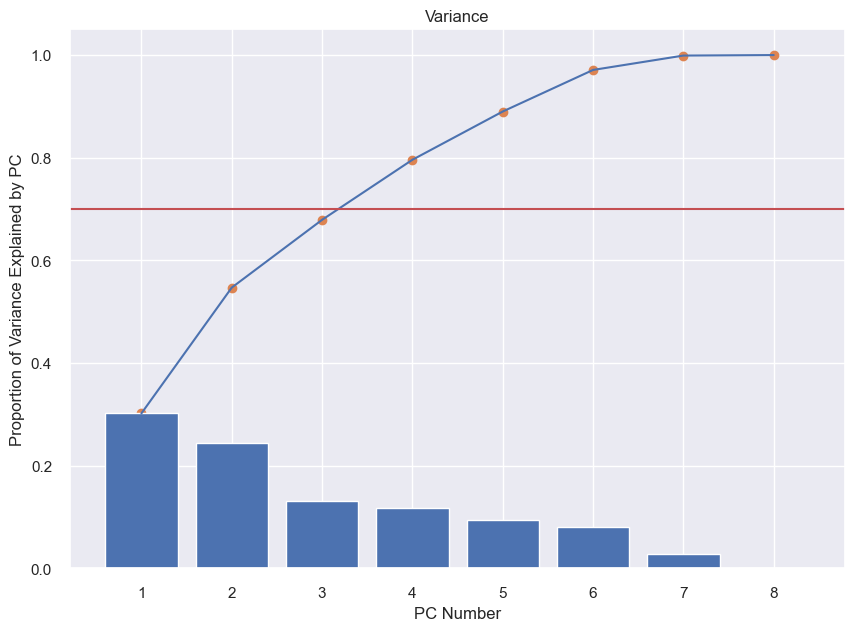

In [78]:
x = list(range(1,N+1))
plt.figure(figsize=(10, 7)) 
plt.bar(x,explained_variance_ratio)
plt.scatter(range(1,N+1),cumulative_variance)
plt.plot(x,cumulative_variance)
plt.title('Variance')
plt.xlabel('PC Number')
plt.ylabel('Proportion of Variance Explained by PC')
plt.axhline(y=0.7, color = 'r')
plt.show()

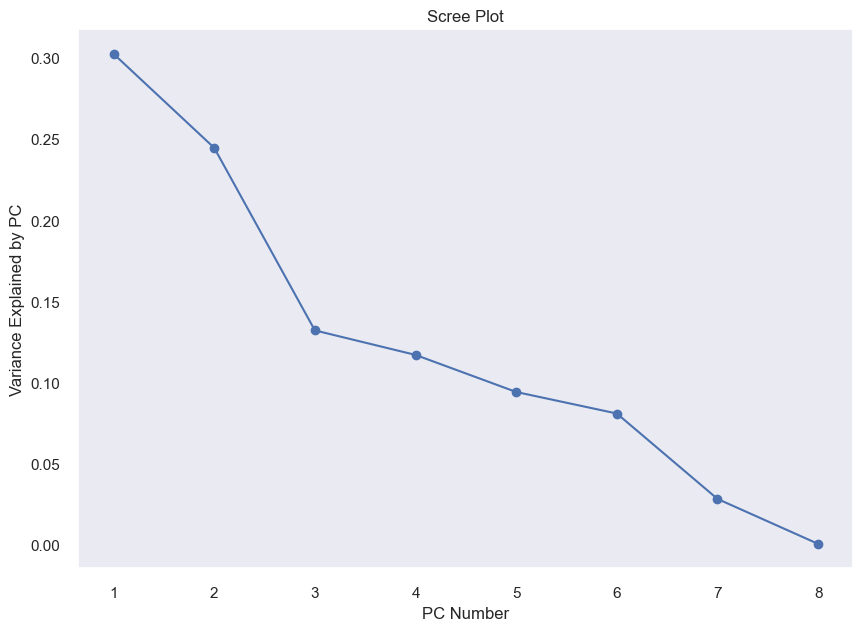

In [79]:
#Scree Plot 
plt.figure(figsize=(10, 7)) 
plt.scatter(range(1,N+1),pca.explained_variance_ratio_)
plt.plot(range(1,N+1),pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('PC Number')
plt.ylabel('Variance Explained by PC')
plt.grid()
plt.show()

In [80]:
kl = KneeLocator(range(1, N+1), pca.explained_variance_ratio_, curve="convex", direction="decreasing")

kl.elbow

3

In [81]:
def CronbachAlpha(itemscores): #calculate the CronbachAlpha to see how closely related a set of items are as a group
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]
    return (nitems / (nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1)))

def variance_explained(num_of_pcs,data):
    # REMARK: we use 'principal' method and 'varimax' rotation in the FactorAnalyzer function.
    f = FactorAnalyzer(n_factors=num_of_pcs,  rotation = 'varimax', method = 'principal')
    f.fit(data)
    return f.get_factor_variance()[2][num_of_pcs-1]

PCA on Scaled Features

In [82]:
# factor analysis
def evaluate_pcs(num_of_pcs,data):
    def encode_vals(x): #helper functions to suppress loading less than 0.7 
    #a gradual process to lead to this function
    # if x<=-0.5, we drop the variable
        if x <= -0.5 or x >= 0.5: #Adjust the threshold value 
            return x
        else:
            return("")    
    f = FactorAnalyzer(n_factors=num_of_pcs, method = 'principal',rotation='varimax') #Conduct PCA + varimax rotation to extract latent factors 
    f.fit(data)
    loadings = pd.DataFrame(f.loadings_).set_index(data.columns)
    loadings = loadings.applymap(encode_vals)
    loadingcols= list(loadings.columns)
    newcols = {}
    for i in loadingcols:
        newcols[i] = "PC" + str(i+1)
    loadings.rename(columns = newcols,inplace=True)
    
    df_pca = f.transform(data)
    return loadings, df_pca

In [83]:
pca_label, df_pca_array = evaluate_pcs(3,scaled_features[colnames])
pca_label

,PC1,PC2,PC3
temperature,0.957891,,
humidity,,-0.629053,0.563945
wind_speed,,0.763389,
visibility,,,-0.672113
dewpoint_temp,0.953116,,
solar_radiation,,0.785694,
rainfall,,,0.603016
snowfall,,,0.543847


In [84]:
df_pca = pd.DataFrame(df_pca_array
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
df_pca

,principal component 1,principal component 2,principal component 3
0,-1.570453,0.095094,-0.751631
1,-1.503011,-0.609114,-1.077123
2,-1.529431,-0.527755,-1.013709
3,-1.522725,-0.592008,-1.023754
4,-1.643061,0.153528,-0.740222
...,...,...,...
8460,-1.026816,0.380679,-0.634283
8461,-1.010183,0.194426,-0.739222
8462,-0.924509,-0.824737,-1.172215
8463,-0.965534,-0.519829,-0.895596


In [85]:
print(CronbachAlpha(scaled_features[['temperature','dewpoint_temp']])) #Reliability of PC1
print(CronbachAlpha(scaled_features[['wind_speed','solar_radiation']])) #Reliability of PC2
print(CronbachAlpha(scaled_features[['rainfall','snowfall', 'humidity']]))

0.9553227868285159
0.49195670229916155
0.28748523484019783


In [86]:
variance_explained(3,scaled_features[colnames])

0.6791092931667145

In [87]:
df_pca_kmean = pd.concat([df_pca, bike[['hour', 'rent_count']]], axis = 1)

In [88]:
df_pca_kmean

,principal component 1,principal component 2,principal component 3,hour,rent_count
0,-1.570453,0.095094,-0.751631,0,254
1,-1.503011,-0.609114,-1.077123,1,204
2,-1.529431,-0.527755,-1.013709,2,173
3,-1.522725,-0.592008,-1.023754,3,107
4,-1.643061,0.153528,-0.740222,4,78
...,...,...,...,...,...
8460,-1.026816,0.380679,-0.634283,19,1003
8461,-1.010183,0.194426,-0.739222,20,764
8462,-0.924509,-0.824737,-1.172215,21,694
8463,-0.965534,-0.519829,-0.895596,22,712


In [89]:
dataarray = df_pca_kmean.to_numpy()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataarray) 
scaled_features

array([[-1.57045274,  0.09509384, -0.75163115, -1.66274762, -0.73975902],
       [-1.50301069, -0.60911442, -1.07712279, -1.51824919, -0.81760266],
       [-1.5294307 , -0.52775531, -1.01370942, -1.37375076, -0.86586572],
       ...,
       [-0.92450854, -0.82473687, -1.17221508,  1.37171942, -0.05473498],
       [-0.96553412, -0.51982924, -0.89559646,  1.51621785, -0.02671127],
       [-0.96077696, -0.39759577, -0.83004685,  1.66071628, -0.22599099]])

In [90]:
pd.DataFrame(scaled_features).describe()

,0,1,2,3,4
count,8.465000e+03,8.465000e+03,8.465000e+03,8.465000e+03,8.465000e+03
mean,2.014533e-17,5.036334e-18,-2.014533e-17,1.208720e-16,-1.678778e-17
std,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00,1.000059e+00
min,-4.292348e+00,-1.775853e+00,-1.603226e+00,-1.662748e+00,-1.132091e+00
25%,-7.023428e-01,-7.838148e-01,-6.108911e-01,-7.957570e-01,-8.020339e-01
50%,1.079776e-01,-2.337570e-01,-2.394596e-01,7.123354e-02,-2.913796e-01
75%,8.410170e-01,6.611985e-01,3.778083e-01,9.382241e-01,5.524454e-01
max,1.886912e+00,5.077124e+00,1.567201e+01,1.660716e+00,4.401035e+00


### Evaluating WCSS

In [91]:
wcss = []
max_k = 14
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

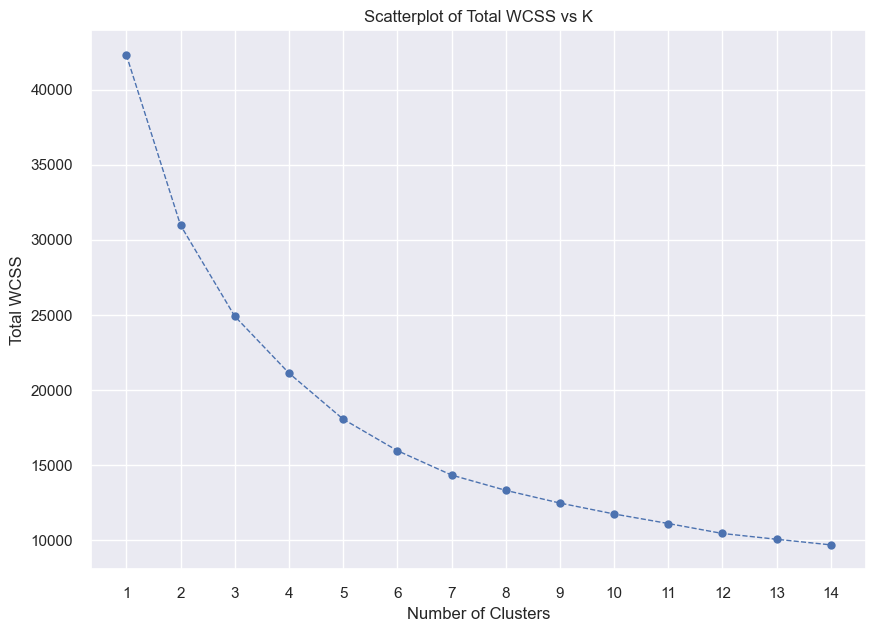

In [92]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [93]:
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

kl.elbow

5

In [94]:
silhouette_coefficients = []

for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)

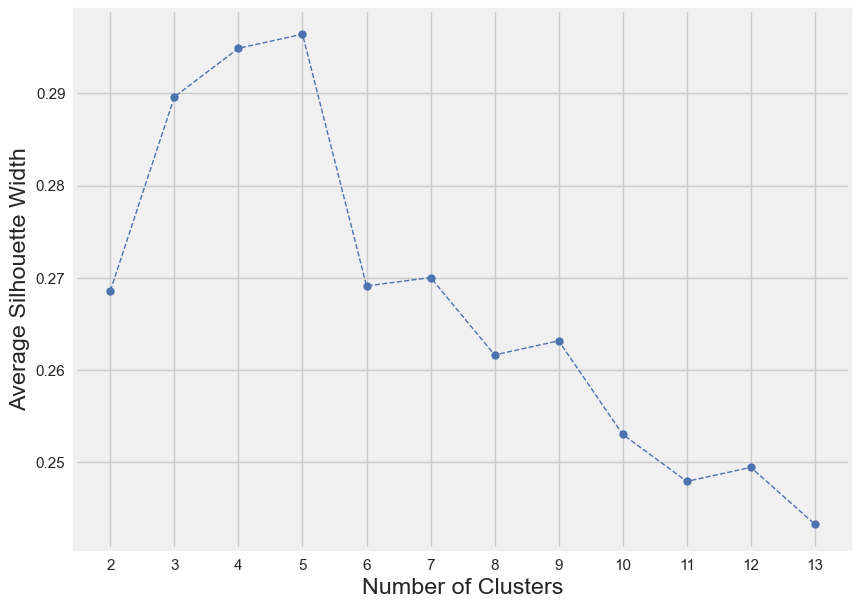

In [95]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

In [96]:
silhouette_dict = {}
def kmeans_label(data, num_clusters): 
    kmeans_model = KMeans(init = 'random', n_clusters = num_clusters, random_state=42)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data.to_numpy()) 
    kmeans_model.fit(scaled_features)
    data2 = data.copy()
    labels = kmeans_model.labels_
    data2['Clusters'] = pd.DataFrame(labels)
    return data2

def plot_boxplots(data_with_label):
    plt.figure(figsize=(30,30))
    sns.set(font_scale = 2)
    for i in range(len(data_with_label.columns)-1):
        plt.subplot(2,5,i+1)
        sns.boxplot(y=data_with_label.columns[i], x='Clusters', data=data_with_label, palette="colorblind") 
    
def plot_silhouettes(data,num_clusters):
    scaler = StandardScaler()
    dataarray = scaler.fit_transform(data.to_numpy()) 
    model = KMeans(num_clusters,random_state=42)
    plt.figure(figsize=(10, 7)) 
    sns.set(font_scale = 1)
    silhouette_visualizer(model, dataarray, colors='yellowbrick')
    score = silhouette_score(dataarray, model.labels_,metric = 'euclidean')
    if num_clusters not in silhouette_dict.keys():
        silhouette_dict[num_clusters] = score
    print("For n_clusters = {0} The average silhouette_score is: {1} ".format(num_clusters,score))

### Kmeans with 5 clusters

In [97]:
kmeans5 = KMeans(init="random",n_clusters =5 , random_state = 42)
kmeans5.fit(scaled_features)
clustergroups5 = kmeans5.labels_
Clustercenters5 = pd.DataFrame(kmeans5.cluster_centers_)
Clustercenters5

print(f'CH score: {calinski_harabasz_score(scaled_features, clustergroups5)}')

CH score: 2839.4832640423224


In [98]:
model5 = kmeans_label(df_pca_kmean, 5)
model5.head()

,principal component 1,principal component 2,principal component 3,hour,rent_count,Clusters
0,-1.570453,0.095094,-0.751631,0,254,1
1,-1.503011,-0.609114,-1.077123,1,204,1
2,-1.529431,-0.527755,-1.013709,2,173,1
3,-1.522725,-0.592008,-1.023754,3,107,1
4,-1.643061,0.153528,-0.740222,4,78,3


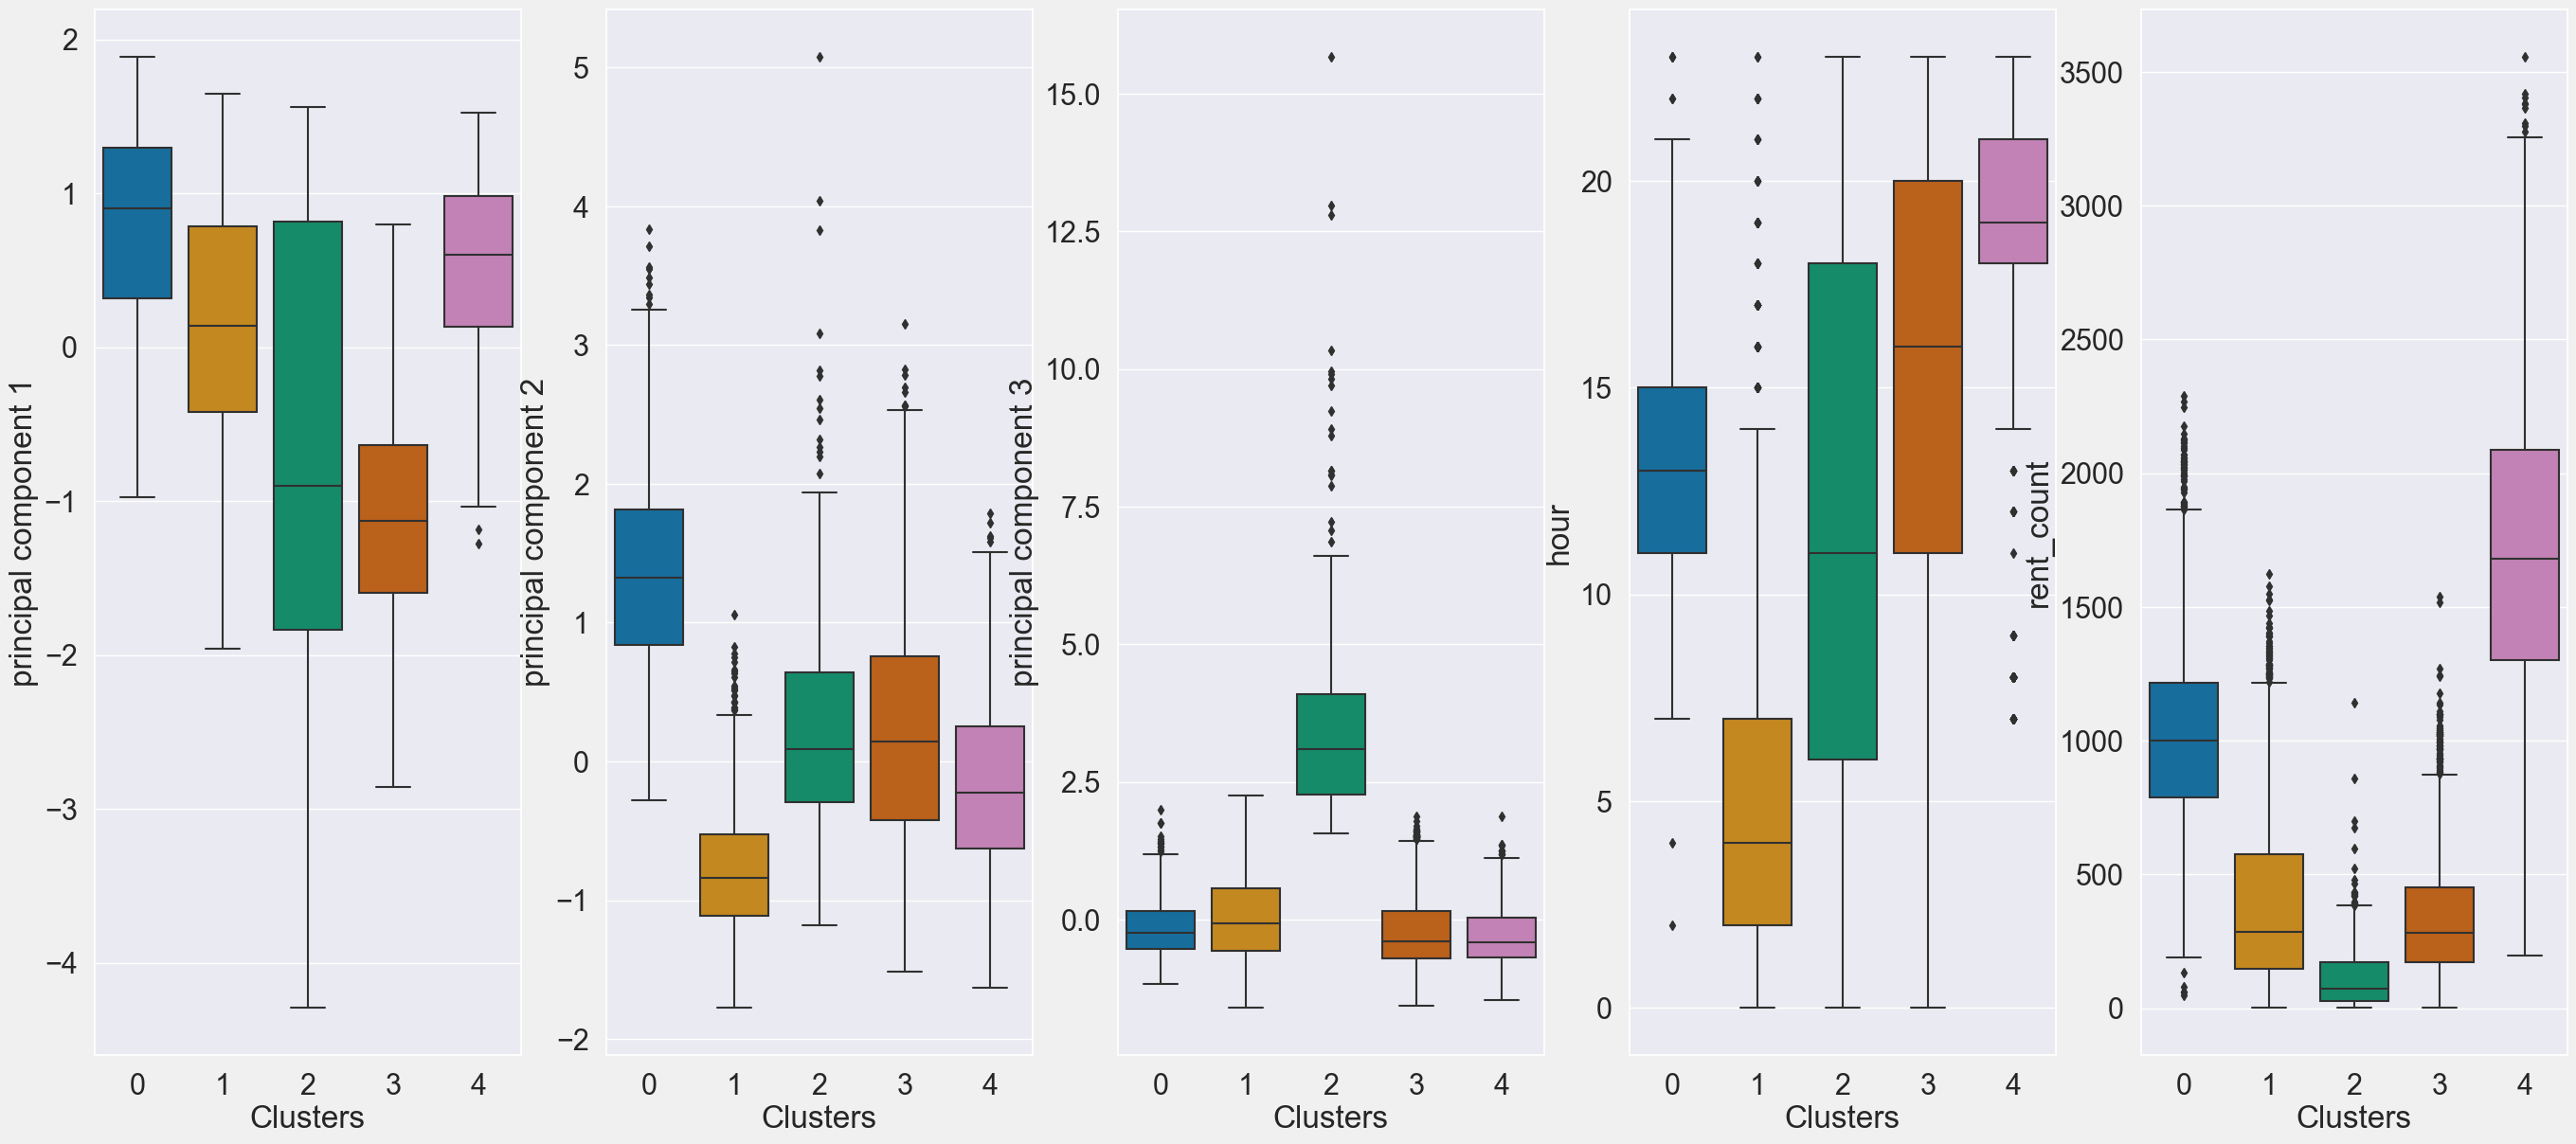

In [99]:
plot_boxplots(model5)
plt.show()

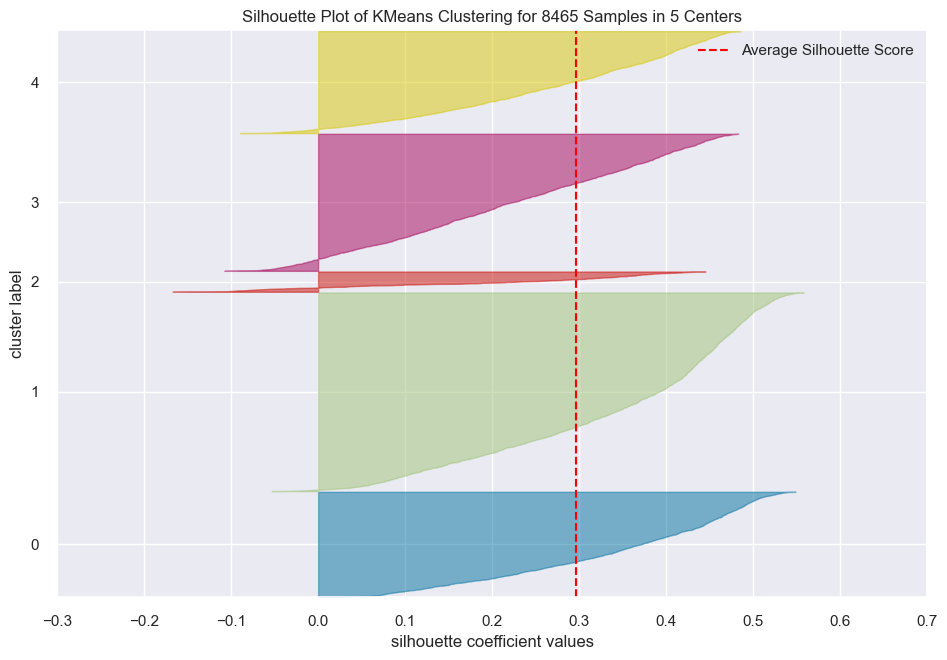

For n_clusters = 5 The average silhouette_score is: 0.2964311070672253 


In [100]:
plot_silhouettes(df_pca_kmean,5)
plt.show()

In [101]:
model5.Clusters.value_counts(dropna=False)

1    2987
3    2061
0    1578
4    1534
2     305
Name: Clusters, dtype: int64

In [102]:
clustergroups5 = kmeans5.labels_
Clustercenters5 = pd.DataFrame(scaler.inverse_transform(kmeans5.cluster_centers_), columns = df_pca_kmean.columns)

In [103]:
Clustercenters5

,principal component 1,principal component 2,principal component 3,hour,rent_count
0,0.803645,1.334943,-0.158413,13.077313,1041.391635
1,0.132264,-0.800381,0.026263,4.684633,388.900904
2,-0.609860,0.264547,3.582280,11.681967,127.098361
3,-1.121577,0.228377,-0.226262,14.862203,340.130519
4,0.543908,-0.174168,-0.296442,18.633638,1712.892438


In [104]:
pca_final_cluster = pd.concat([model5, bike[['season', 'holiday', 'open']]], axis = 1)

In [105]:
pca_season = pca_final_cluster.groupby('Clusters').season.agg(pd.Series.mode).to_frame()

In [106]:
pca_holiday = pca_final_cluster.groupby('Clusters').holiday.agg(pd.Series.mode).to_frame()

In [107]:
pca_open = pca_final_cluster.groupby('Clusters').open.agg(pd.Series.mode).to_frame()

In [108]:
final_pca_cluster = pd.concat([Clustercenters5,pca_season, pca_holiday, pca_open], axis=1)
final_pca_cluster

,principal component 1,principal component 2,principal component 3,hour,rent_count,season,holiday,open
0,0.803645,1.334943,-0.158413,13.077313,1041.391635,Summer,No Holiday,Yes
1,0.132264,-0.800381,0.026263,4.684633,388.900904,Spring,No Holiday,Yes
2,-0.609860,0.264547,3.582280,11.681967,127.098361,Winter,No Holiday,Yes
3,-1.121577,0.228377,-0.226262,14.862203,340.130519,Winter,No Holiday,Yes
4,0.543908,-0.174168,-0.296442,18.633638,1712.892438,Summer,No Holiday,Yes


In [109]:
pca_label

,PC1,PC2,PC3
temperature,0.957891,,
humidity,,-0.629053,0.563945
wind_speed,,0.763389,
visibility,,,-0.672113
dewpoint_temp,0.953116,,
solar_radiation,,0.785694,
rainfall,,,0.603016
snowfall,,,0.543847


### Clustering on Aggregate Data

In [180]:
bike_agg = pd.read_csv('../PCA/bike_agg_with_season_no.csv')
bike_agg = bike_agg[bike_agg.rent_count > 0].reset_index(drop=True)

In [181]:
bike_agg.describe()

,Unnamed: 0,rent_count,temperature,rainfall,snowfall,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity,season_no
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,177.000000,17485.308782,12.606232,3.575921,18.628895,1.640935,14681.076487,0.109589,3.850992,57.957507,2.484419
std,102.046558,9937.164768,11.568233,11.789868,88.044126,0.661204,5578.420791,0.154109,13.194681,16.100348,1.128359
min,1.000000,977.000000,-14.850000,0.000000,0.000000,0.000000,2185.000000,0.000000,-27.900000,22.000000,1.000000
25%,89.000000,6967.000000,2.900000,0.000000,0.000000,1.150000,9795.000000,0.000000,-5.350000,46.500000,1.000000
50%,177.000000,18563.000000,13.500000,0.000000,0.000000,1.500000,16765.000000,0.015000,4.550000,56.000000,2.000000
75%,265.000000,26285.000000,22.400000,0.500000,0.000000,1.950000,19875.000000,0.190000,15.200000,69.000000,4.000000
max,353.000000,36149.000000,33.100000,95.500000,787.000000,4.000000,20000.000000,0.575000,25.000000,97.000000,4.000000


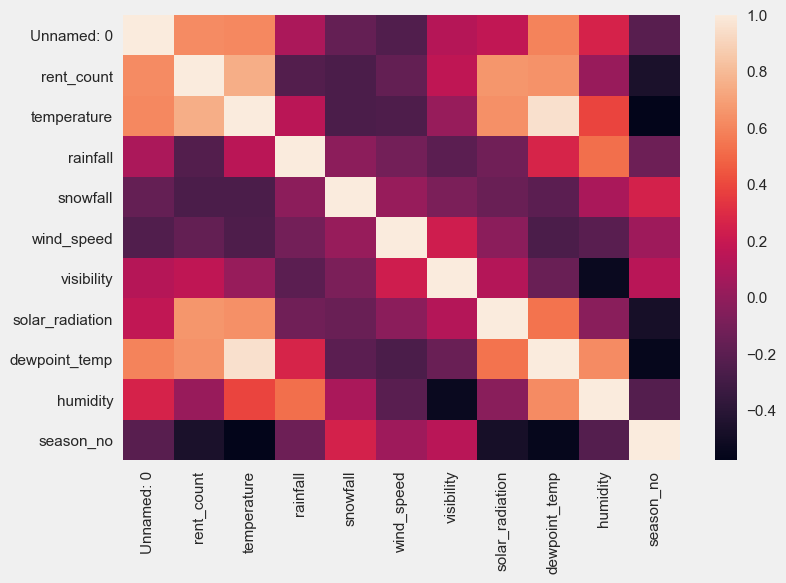

In [182]:
sns.heatmap(bike_agg.corr())
plt.show()

## K means clustering
### Scaling Data

In [183]:
# drop categorical var: holiday, season
# drop dewpoint_temp (correlated with temperature
# drop rainfall & snowfall (more than 93% is 0)

In [184]:
df_kmean_agg = bike_agg.drop(columns = ['Unnamed: 0','holiday', 'season', 'date',
                               'rainfall', 'snowfall', 'dewpoint_temp', 'season_no'])

In [185]:
df_kmean_agg.columns

Index(['rent_count', 'temperature', 'wind_speed', 'visibility',
       'solar_radiation', 'humidity'],
      dtype='object')

In [186]:
df_kmean_agg.describe()

,rent_count,temperature,wind_speed,visibility,solar_radiation,humidity
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,17485.308782,12.606232,1.640935,14681.076487,0.109589,57.957507
std,9937.164768,11.568233,0.661204,5578.420791,0.154109,16.100348
min,977.000000,-14.850000,0.000000,2185.000000,0.000000,22.000000
25%,6967.000000,2.900000,1.150000,9795.000000,0.000000,46.500000
50%,18563.000000,13.500000,1.500000,16765.000000,0.015000,56.000000
75%,26285.000000,22.400000,1.950000,19875.000000,0.190000,69.000000
max,36149.000000,33.100000,4.000000,20000.000000,0.575000,97.000000


In [187]:
dataarray = df_kmean_agg.to_numpy()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataarray) 
scaled_features

array([[-0.8007906 , -1.18649822, -0.36490546,  0.95483536, -0.71212397,
        -1.27242875],
       [-0.90317817, -0.85754617, -0.06199746, -0.04866274, -0.71212397,
        -0.15285355],
       [-1.03428666, -0.71471172, -0.06199746, -2.02873146, -0.71212397,
         1.65090648],
       ...,
       [-0.09687605, -0.69307014, -0.06199746, -0.00737391, -0.71212397,
        -1.9877129 ],
       [-0.10705435, -0.84888953, -0.97072147,  0.13623941, -0.71212397,
        -1.39682599],
       [-0.11975202, -0.9181426 , -0.51635947, -0.10431291, -0.71212397,
        -0.93033633]])

### Evaluating WCSS

In [188]:
wcss = []
max_k = 14
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

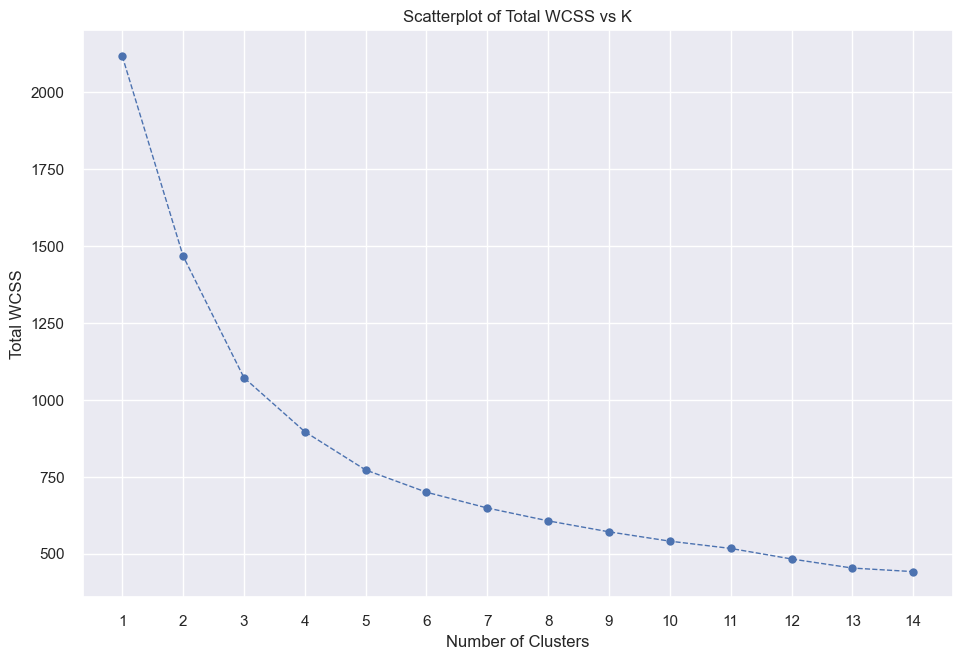

In [189]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [190]:
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

kl.elbow

4

In [191]:
silhouette_coefficients = []

for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)

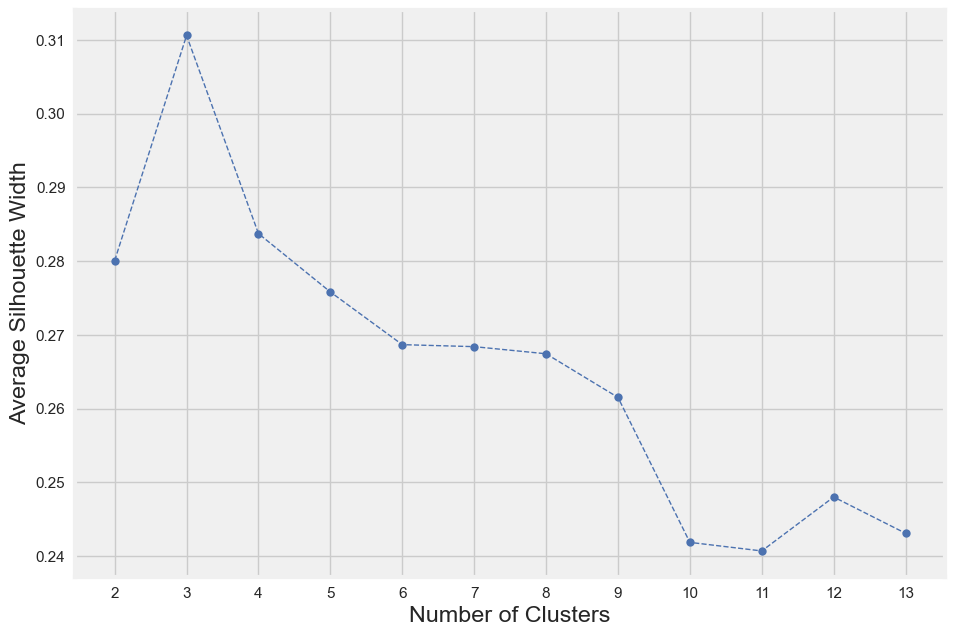

In [192]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

In [193]:
silhouette_dict = {}
def kmeans_label(data, num_clusters): 
    kmeans_model = KMeans(init = 'random', n_clusters = num_clusters, random_state=42)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data.to_numpy()) 
    kmeans_model.fit(scaled_features)
    data2 = data.copy()
    labels = kmeans_model.labels_
    data2['Clusters'] = pd.DataFrame(labels)
    return data2

def plot_boxplots(data_with_label):
    plt.figure(figsize=(30,30))
    sns.set(font_scale = 2)
    for i in range(len(data_with_label.columns)-1):
        plt.subplot(2,5,i+1)
        sns.boxplot(y=data_with_label.columns[i], x='Clusters', data=data_with_label, palette="colorblind") 
    
def plot_silhouettes(data,num_clusters):
    scaler = StandardScaler()
    dataarray = scaler.fit_transform(data.to_numpy()) 
    model = KMeans(num_clusters,random_state=42)
    plt.figure(figsize=(10, 7)) 
    sns.set(font_scale = 1)
    silhouette_visualizer(model, dataarray, colors='yellowbrick')
    score = silhouette_score(dataarray, model.labels_,metric = 'euclidean')
    if num_clusters not in silhouette_dict.keys():
        silhouette_dict[num_clusters] = score
    print("For n_clusters = {0} The average silhouette_score is: {1} ".format(num_clusters,score))

### Kmeans with 4 clusters

In [194]:
kmeans4 = KMeans(init="random",n_clusters = 4 , random_state = 42)
kmeans4.fit(scaled_features)
clustergroups4 = kmeans4.labels_
Clustercenters4 = pd.DataFrame(kmeans4.cluster_centers_)
Clustercenters4

,0,1,2,3,4,5
0,-0.507373,-0.156110,-0.394500,-1.384545,-0.486557,0.998536
1,-1.061186,-1.254423,0.664293,0.537184,-0.687387,-0.925742
2,1.025496,1.010334,-0.026904,0.227300,1.633935,-0.164990
3,0.556615,0.428370,-0.228439,0.568173,-0.324606,0.084603


In [195]:
print(f'CH score: {calinski_harabasz_score(scaled_features, clustergroups4)}')

CH score: 158.2055017315656


In [196]:
model4 = kmeans_label(df_kmean_agg, 4)
model4.head()

,rent_count,temperature,wind_speed,visibility,solar_radiation,humidity,Clusters
0,9539,-1.10,1.4,20000,0.0,37.5,1
1,8523,2.70,1.6,14410,0.0,55.5,1
2,7222,4.35,1.6,3380,0.0,84.5,0
3,8729,-0.25,3.6,19130,0.0,43.5,1
4,8307,-3.80,0.0,20000,0.0,34.5,1


In [197]:
model4.Clusters.value_counts(dropna=False)

3    96
1    88
0    87
2    82
Name: Clusters, dtype: int64

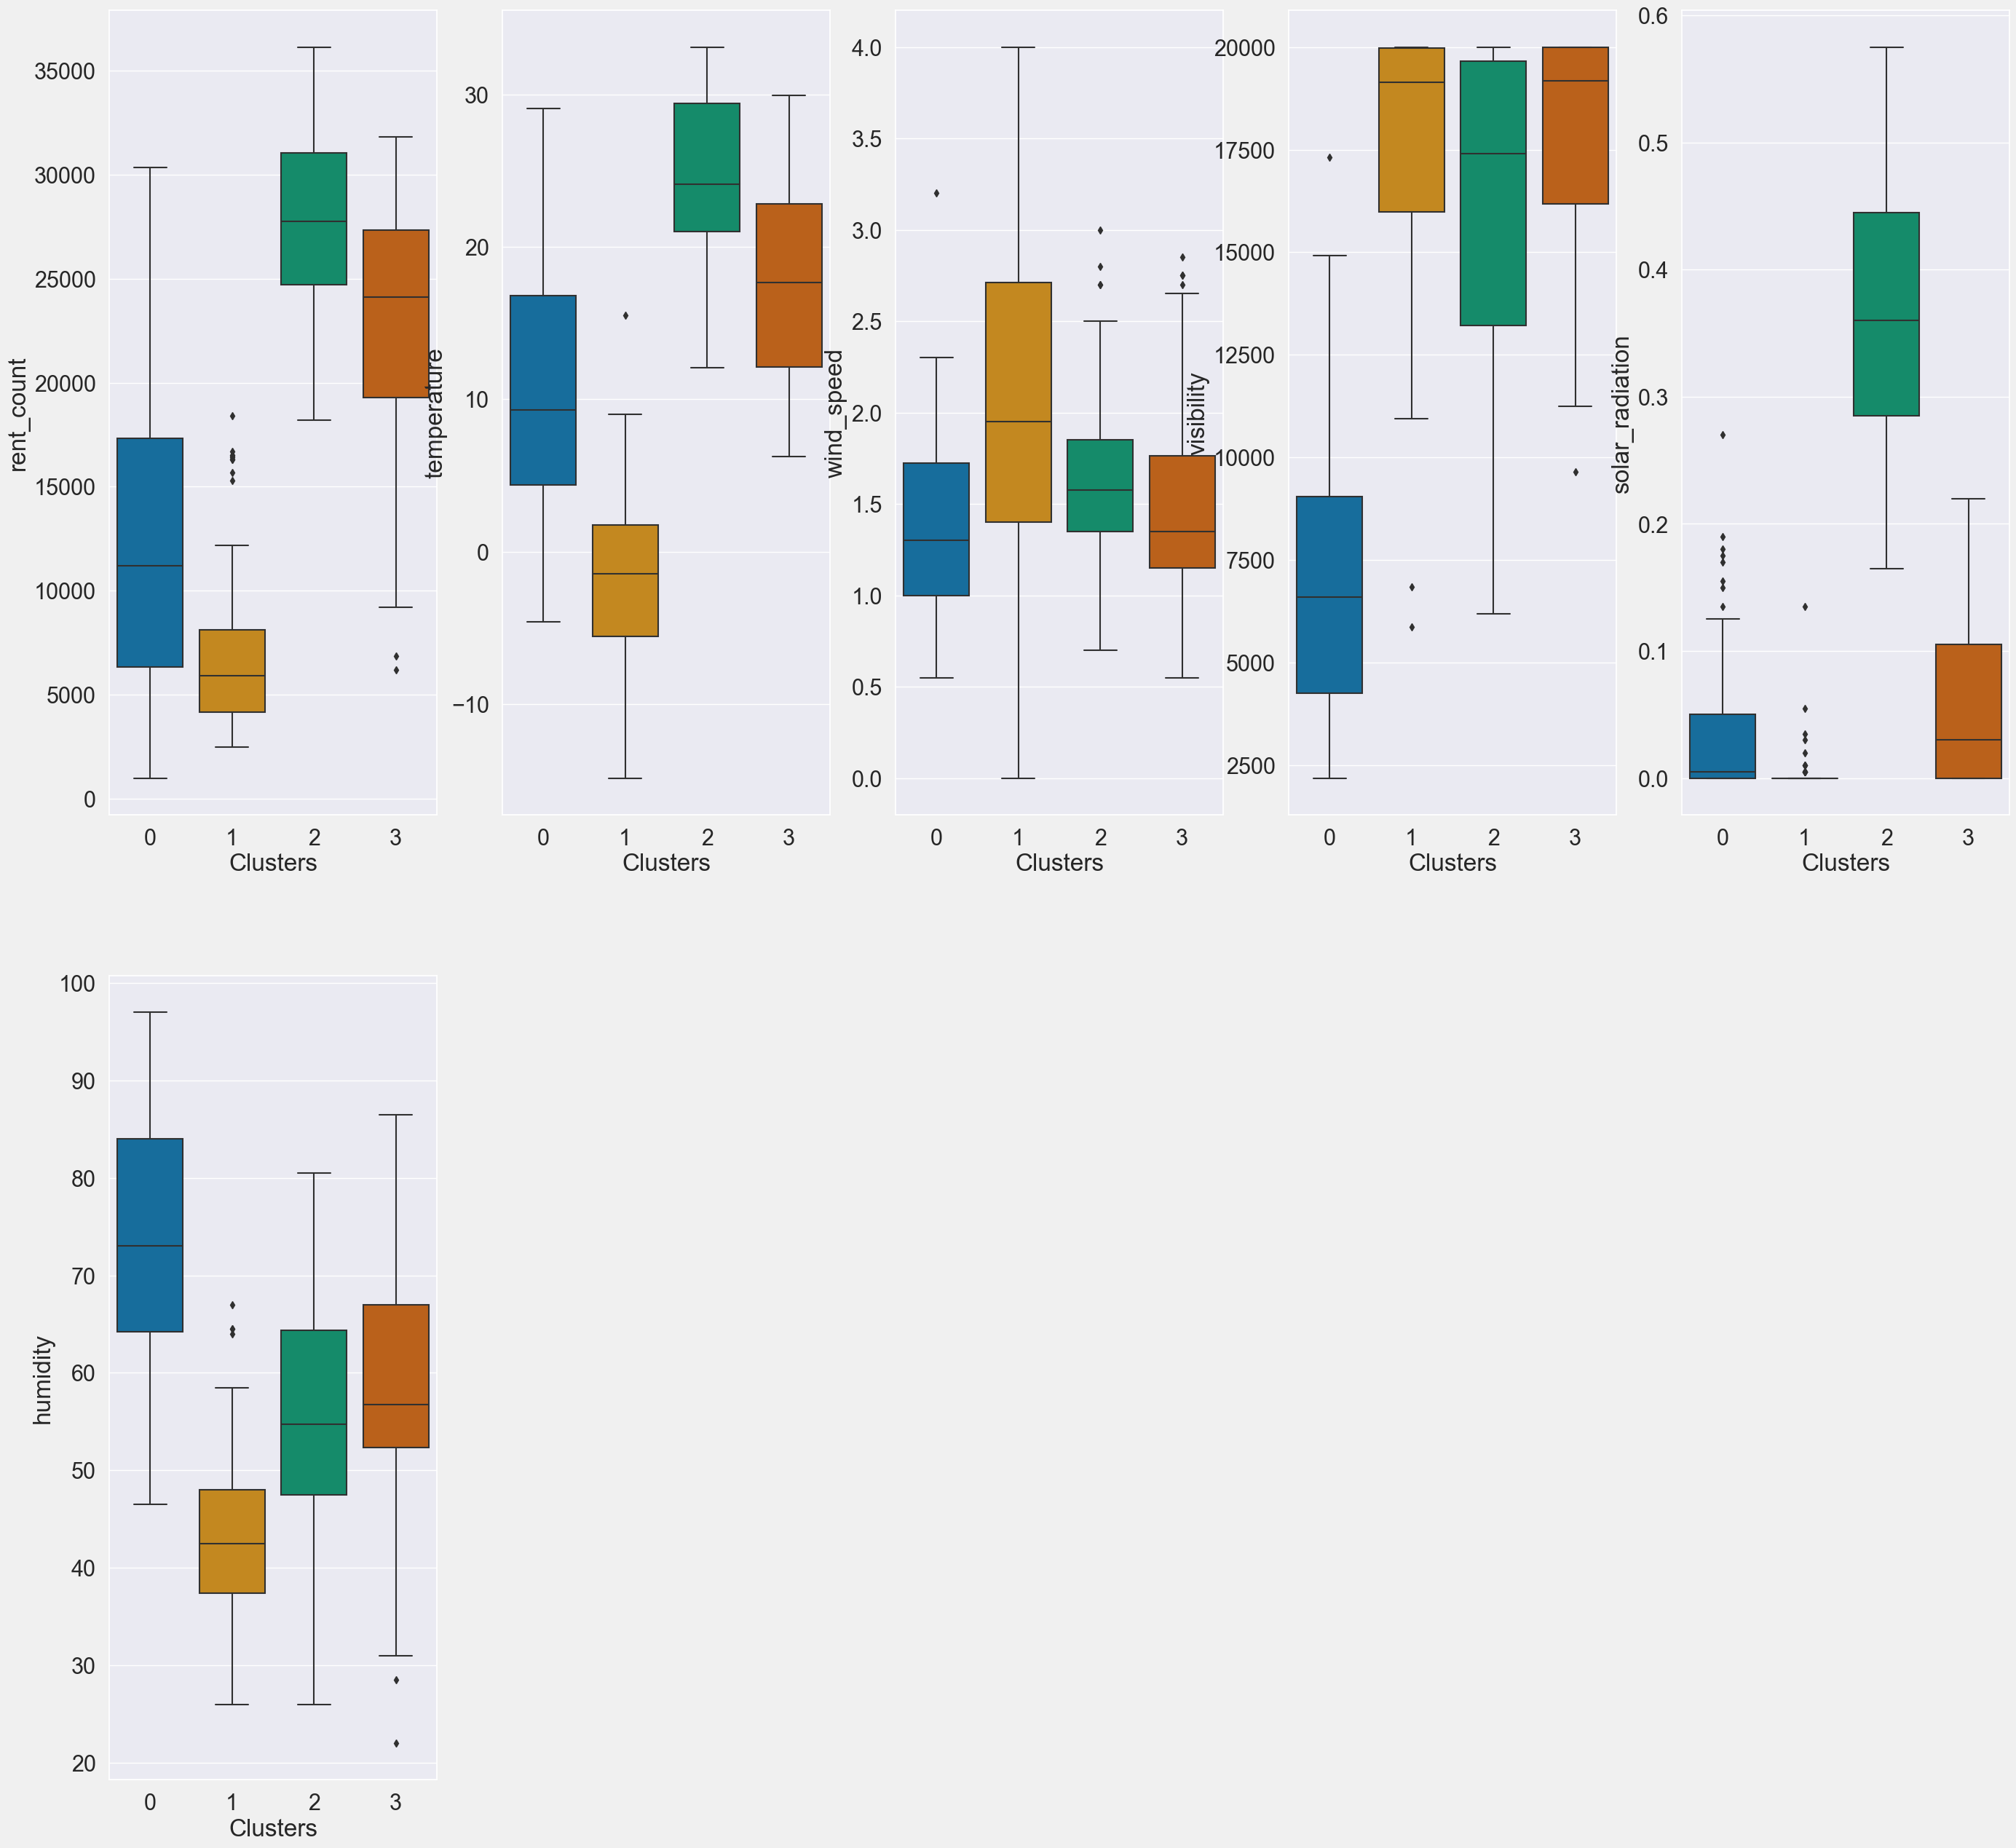

In [198]:
plot_boxplots(model4)
plt.show()

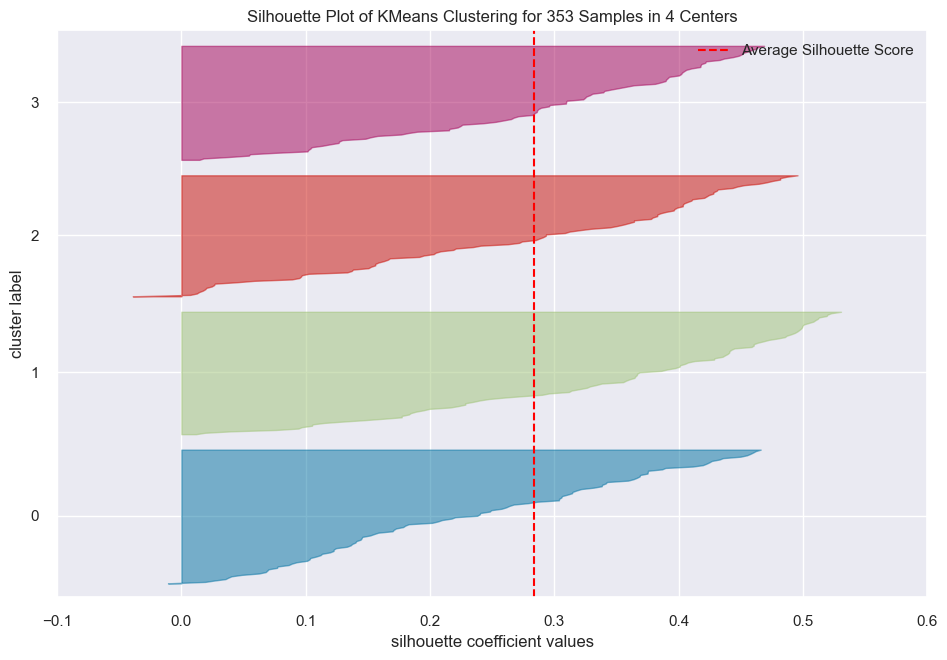

For n_clusters = 4 The average silhouette_score is: 0.28372758262588144 


In [199]:
plot_silhouettes(df_kmean_agg,4)
plt.show()

In [200]:
Clustercenters4 = pd.DataFrame(scaler.inverse_transform(kmeans4.cluster_centers_), columns = df_kmean_agg.columns)

In [201]:
Clustercenters4

,rent_count,temperature,wind_speed,visibility,solar_radiation,humidity
0,12450.609195,10.802874,1.380460,6968.448276,0.034713,74.011494
1,6955.079545,-1.884659,2.079545,17673.465909,0.003807,43.073864
2,27661.390244,24.277439,1.623171,15947.256098,0.361037,55.304878
3,23008.645833,17.554688,1.490104,17846.093750,0.059635,59.317708


In [211]:
final_cluster = pd.concat([model4, bike_agg[['season', 'holiday']]], axis = 1)

In [213]:
cluster_season = final_cluster.groupby('Clusters').season.agg(pd.Series.mode).to_frame()

In [214]:
cluster_holiday = final_cluster.groupby('Clusters').holiday.agg(pd.Series.mode).to_frame()

In [215]:
final_cluster_center = pd.concat([Clustercenters4,cluster_season, cluster_holiday], axis=1)
final_cluster_center

,rent_count,temperature,wind_speed,visibility,solar_radiation,humidity,season,holiday
0,12450.609195,10.802874,1.380460,6968.448276,0.034713,74.011494,Spring,No Holiday
1,6955.079545,-1.884659,2.079545,17673.465909,0.003807,43.073864,Winter,No Holiday
2,27661.390244,24.277439,1.623171,15947.256098,0.361037,55.304878,Summer,No Holiday
3,23008.645833,17.554688,1.490104,17846.093750,0.059635,59.317708,Autumn,No Holiday


In [216]:
model4.Clusters.value_counts(dropna=False)

3    96
1    88
0    87
2    82
Name: Clusters, dtype: int64